In [40]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix


In [41]:
loan_data = pd.read_csv('Loan_Data.csv')

In [42]:
loan_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [43]:
len(loan_data)

10000

In [44]:
loan_data.columns

Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'default'],
      dtype='object')

In [45]:
train, test = train_test_split(loan_data, test_size=0.2)

In [46]:
train.columns.tolist()

['customer_id',
 'credit_lines_outstanding',
 'loan_amt_outstanding',
 'total_debt_outstanding',
 'income',
 'years_employed',
 'fico_score',
 'default']

In [47]:


# Variables d'entrée (sans customer_id)
input_variable = [
    'credit_lines_outstanding', 
    'loan_amt_outstanding',
    'total_debt_outstanding', 
    'income', 
    'years_employed', 
    'fico_score',
]

# Préparation des données
X_train = train[input_variable]
y_train = train['default']
X_test = test[input_variable]
y_test = test['default']

# Modèle RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Validation croisée
cv_auc = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='roc_auc')
cv_accuracy = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy')
cv_precision = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='precision')
cv_recall = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='recall')

print("=== VALIDATION CROISÉE ===")
print(f"CV AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")
print(f"CV Accuracy: {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
print(f"CV Precision: {cv_precision.mean():.4f} ± {cv_precision.std():.4f}")
print(f"CV Recall: {cv_recall.mean():.4f} ± {cv_recall.std():.4f}")

# Entraînement final
rf_clf.fit(X_train, y_train)

# Prédictions sur le test set
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]  # Probabilités pour la classe 1 (défaut)
y_pred = rf_clf.predict(X_test)  # Prédictions binaires

print("\n=== PERFORMANCE SUR LE TEST SET ===")
print(f"Test AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

=== VALIDATION CROISÉE ===
CV AUC: 0.9998 ± 0.0001
CV Accuracy: 0.9945 ± 0.0011
CV Precision: 0.9860 ± 0.0099
CV Recall: 0.9844 ± 0.0104

=== PERFORMANCE SUR LE TEST SET ===
Test AUC: 0.9999
Test Accuracy: 0.9965

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1628
           1       0.99      0.99      0.99       372

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000


Confusion Matrix:
[[1625    3]
 [   4  368]]


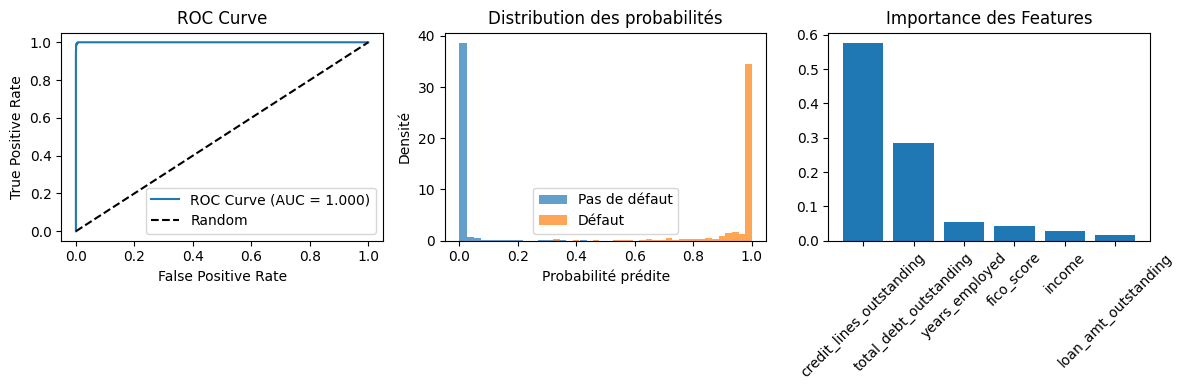


=== IMPORTANCE DES FEATURES ===
credit_lines_outstanding: 0.5771
total_debt_outstanding: 0.2836
years_employed: 0.0532
fico_score: 0.0415
income: 0.0283
loan_amt_outstanding: 0.0163


In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# 1. Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# 2. Distribution des probabilités
plt.subplot(1, 3, 2)
plt.hist(y_pred_proba[y_test==0], bins=30, alpha=0.7, label='Pas de défaut', density=True)
plt.hist(y_pred_proba[y_test==1], bins=30, alpha=0.7, label='Défaut', density=True)
plt.xlabel('Probabilité prédite')
plt.ylabel('Densité')
plt.title('Distribution des probabilités')
plt.legend()

# 3. Importance des features
plt.subplot(1, 3, 3)
feature_importance = rf_clf.feature_importances_
indices = np.argsort(feature_importance)[::-1]

plt.bar(range(len(feature_importance)), feature_importance[indices])
plt.xticks(range(len(feature_importance)), [input_variable[i] for i in indices], rotation=45)
plt.title('Importance des Features')
plt.tight_layout()
plt.show()

# Afficher l'importance numérique
print("\n=== IMPORTANCE DES FEATURES ===")
for i in indices:
    print(f"{input_variable[i]}: {feature_importance[i]:.4f}")